<a href="https://colab.research.google.com/github/az2611/Berkeley_Capstone_Final/blob/main/Berkeley_BERTv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Claims Classification with Deep Learning using BERT

### Project Outline

**Task 1**: Introduction (this section)

**Task 2**: Exploratory Data Analysis and Preprocessing

**Task 3**: Training/Validation Split

**Task 4**: Loading Tokenizer and Encoding our Data

**Task 5**: Setting up BERT Pretrained Model

**Task 6**: Creating Data Loaders

**Task 7**: Setting Up Optimizer and Scheduler

**Task 8**: Defining our Performance Metrics

**Task 9**: Creating our Training Loop

**Task 10**: Loading and Evaluating our Model

## Task 1: Introduction

### What is BERT

BERT is a large-scale transformer-based Language Model that can be finetuned for a variety of tasks.

For more information, the original paper can be found [here](https://arxiv.org/abs/1810.04805). 

[HuggingFace documentation](https://huggingface.co/transformers/model_doc/bert.html)

[Bert documentation](https://characters.fandom.com/wiki/Bert_(Sesame_Street) )

## Task 2: Exploratory Data Analysis and Preprocessing

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Loss_Classification/Loss_Description.csv')

In [ ]:
#Remove Unknows
df = df[df.Class!='Unknown']

In [ ]:
#Remove low classes
df = df[~df['Class'].isin(['auto-related','Auto-related','Theft'])]

In [ ]:
df.head()

,Description,Class
0,VWF,Occupational disease/illness
1,CLAIMANT FELL AND INJURED WRIST,Fell
2,FELL ON ROADWAY AND INJURED BUTTOCKS,Fell
3,FELL ON RAIL TRACK NIL DED,Fell
4,STEEL FELL ON CLMNTS LEGS NIL DED,Fell


In [ ]:
#df = df.drop('Unnamed: 0', axis = 1)
df = df.rename({'Class': 'category', 'Description': 'text'}, axis = 1)
df

,text,category
0,VWF,Occupational disease/illness
1,CLAIMANT FELL AND INJURED WRIST,Fell
2,FELL ON ROADWAY AND INJURED BUTTOCKS,Fell
3,FELL ON RAIL TRACK NIL DED,Fell
4,STEEL FELL ON CLMNTS LEGS NIL DED,Fell
...,...,...
2306,As a result of a water hydrant being opened th...,Damage
2307,claimant suffered head and knee injuries by fa...,Injury
2308,CLAIMANT SLIPPED ON ICE IN CAR PARK,Injury
2309,Claimant slipped on loose gravel causing injury,Injury


In [ ]:
df['category'].value_counts(dropna = False)

Injury                          842
Fell                            509
Damage                          192
Water                           157
Occupational disease/illness    146
Flood                            62
Pollution                        62
Fire                             44
Name: category, dtype: int64

In [ ]:
df = df.dropna()
df.shape

(2014, 2)

In [ ]:
len(df['text'].unique())

2006

In [ ]:
possible_labels = df.category.unique()

In [ ]:
label_dict = {}
for index, possible_label in enumerate (possible_labels):
     label_dict[possible_label]=index 

In [ ]:
df['label']=df.category.replace(label_dict)
df.head()

,text,category,label
0,VWF,Occupational disease/illness,0
1,CLAIMANT FELL AND INJURED WRIST,Fell,1
2,FELL ON ROADWAY AND INJURED BUTTOCKS,Fell,1
3,FELL ON RAIL TRACK NIL DED,Fell,1
4,STEEL FELL ON CLMNTS LEGS NIL DED,Fell,1


In [ ]:
label_dict

{'Occupational disease/illness': 0,
 'Fell': 1,
 'Flood': 2,
 'Injury': 3,
 'Pollution': 4,
 'Damage': 5,
 'Water': 6,
 'Fire': 7}

## Task 3: Training/Validation Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.30,
                                                  random_state=17,
                                                  stratify=df.label.values)

In [ ]:
X_val.shape

(605,)

In [ ]:
df['data_type']=['not_set']*df.shape[0]

In [ ]:
df.loc[X_train, 'data_type']='train'
df.loc[X_val, 'data_type']='val'

validation_df = df[df['data_type'] == 'val'].reset_index(drop = True)

In [ ]:
validation_df.head()

,text,category,label,data_type
0,CLAIMANT FELL AND INJURED WRIST,Fell,1,val
1,FELL ON ROADWAY AND INJURED BUTTOCKS,Fell,1,val
2,FELL ON RAIL TRACK NIL DED,Fell,1,val
3,OIL SPILLAGE,Pollution,4,val
4,GATE FELL LEG 10000 TPPD XS,Injury,3,val


In [ ]:
df.groupby(['category','label','data_type']).count()

text
category                     label data_type      
Damage                       5     train       134
                                   val          58
Fell                         1     train       356
                                   val         153
Fire                         7     train        31
                                   val          13
Flood                        2     train        44
                                   val          18
Injury                       3     train       589
                                   val         253
Occupational disease/illness 0     train       102
                                   val          44
Pollution                    4     train        43
                                   val          19
Water                        6     train       110
                                   val          47

## Task 4: Loading Tokenizer and Encoding our Data

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [ ]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-large-uncased',
    do_lower_case=True
    )

In [ ]:
encoded_data_train  = tokenizer.batch_encode_plus(
    df[df.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

encoded_data_val  = tokenizer.batch_encode_plus(
    df[df.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train=torch.tensor(df[df.data_type=='train'].label.values)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(df[df.data_type=='val'].label.values)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
dataset_train = TensorDataset(input_ids_train,
                              attention_masks_train, labels_train)

dataset_val = TensorDataset(input_ids_val,
                            attention_masks_val, labels_val)

In [ ]:
len(dataset_train)

1409

In [ ]:
len(dataset_val)

605

## Task 5: Setting up BERT Pretrained Model

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    'bert-large-uncased', 
    num_labels = len(label_dict),
    output_attentions=False,
    output_hidden_states=False
)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

## Task 6: Creating Data Loaders

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [ ]:
batch_size = 12 # was 4 for AZ results

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=SequentialSampler(dataset_val),
    batch_size=32
)

## Task 7: Setting Up Optimizer and Scheduler

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
optimizer = AdamW(
    model.parameters(),
    lr=1e-5, #2e-5 > 5e-5
    eps=1e-8
)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
epochs = 5 # was 25 epochs for AZ results

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs
)

## Task 8: Defining our Performance Metrics

Accuracy metric approach originally used in accuracy function in [this tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/#41-bertforsequenceclassification).

In [ ]:
import numpy as np

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

In [ ]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

## Task 9: Creating our Training Loop

Approach adapted from an older version of HuggingFace's `run_glue.py` script. Accessible [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128).

In [ ]:
import random
import numpy as np

seed_val = 34
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
          
        
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Feb 14 01:04:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |  14194MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
logging_df = pd.DataFrame(columns = ['epoch', 'training_loss', 'val_loss', 'val_f1'])

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch),
                       leave=False,
                       disable=False
                       )
    
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids'      :batch[0],
            'attention_mask' :batch[1],
            'labels'         :batch[2]
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})
    
    #torch.save(model.state_dict(),f'/content/drive/MyDrive/Loss_Classification/Models/Bert_ft_epoch{epoch}.model') 
                                 
    tqdm.write(f'\nEpoch {epoch}')      
                                 
    loss_train_avg = loss_train_total/len(dataloader_train)
                                 
    tqdm.write(f'Training loss: {loss_train_avg}')
                                 
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')
    logging_df = logging_df.append({'epoch': int(epoch), 'training_loss': loss_train_avg,
                                    'val_loss': val_loss, 'val_f1': val_f1}, ignore_index = True)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.2735248526274148


  0%|          | 0/19 [00:00<?, ?it/s]

Validation loss: 0.7500910429578078
F1 Score (weighted): 0.7402515110982062


Epoch 2:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.5827056989705158


  0%|          | 0/19 [00:00<?, ?it/s]

Validation loss: 0.47805753389471456
F1 Score (weighted): 0.8422658853283332


Epoch 3:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.3365176137915607


  0%|          | 0/19 [00:00<?, ?it/s]

Validation loss: 0.3544365659748253
F1 Score (weighted): 0.901273228878211


Epoch 4:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.21818485789758674


  0%|          | 0/19 [00:00<?, ?it/s]

Validation loss: 0.3299045088259797
F1 Score (weighted): 0.915922323384146


Epoch 5:   0%|          | 0/118 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.16846719616234807


  0%|          | 0/19 [00:00<?, ?it/s]

Validation loss: 0.3367914965278224
F1 Score (weighted): 0.9109060191176175


In [ ]:
torch.save(model.state_dict(), f'/content/drive/MyDrive/Loss_Classification/models/Bert_claims2_{epochs}_epochs.pt')

In [ ]:
logging_df.to_csv('/content/drive/MyDrive/Loss_Classification/models/BERTv2_stats.csv')

## Task 10: Loading and Evaluating our Model

In [ ]:
logging_df = pd.read_csv('/content/drive/MyDrive/Loss_Classification/models/BERTv2_stats.csv')
logging_df.drop('Unnamed: 0', axis = 1, inplace = True)
logging_df.head()

,epoch,training_loss,val_loss,val_f1
0,1.0,1.273525,0.750091,0.740252
1,2.0,0.582706,0.478058,0.842266
2,3.0,0.336518,0.354437,0.901273
3,4.0,0.218185,0.329905,0.915922
4,5.0,0.168467,0.336791,0.910906


3


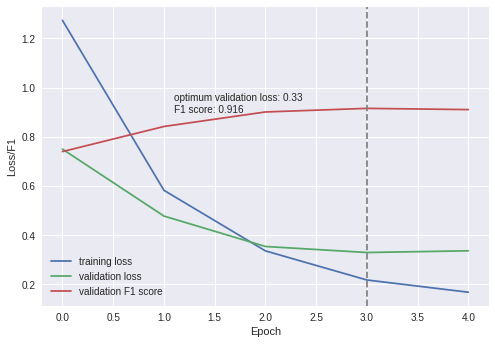

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# annotating with relevant points
min_val_loss = min(logging_df['val_loss'])
min_val_loss_epoch = logging_df['val_loss'].idxmin()

print(min_val_loss_epoch)

highest_f1 = max(logging_df['val_f1'])
max_f1_epoch = logging_df['val_f1'].idxmax()
f1_at_best_loss = logging_df['val_f1'][min_val_loss_epoch]

# creating the plot with all 3 metrics across all epochs
plt.plot(logging_df['training_loss'], label = 'training loss')
plt.plot(logging_df['val_loss'], label = 'validation loss')
plt.plot(logging_df['val_f1'], label = 'validation F1 score')
plt.xlabel('Epoch')
plt.ylabel('Loss/F1')
plt.axvline(x=min_val_loss_epoch, color='grey', linestyle='--')
plt.annotate(f'optimum validation loss: {round(min_val_loss, 3)}\nF1 score: {round(f1_at_best_loss, 3)}', xy = (1.1, 0.9))
plt.legend();



In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-large-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

In [ ]:
model.to(device)
pass

In [ ]:
model.load_state_dict(
    torch.load(f'/content/drive/MyDrive/Loss_Classification/models/Bert_claims2_{epochs}_epochs.pt',
              map_location=torch.device('cuda')))

<All keys matched successfully>

In [ ]:
_, predictions, true_vals = evaluate(dataloader_val)

  0%|          | 0/19 [00:00<?, ?it/s]

In [ ]:
accuracy_per_class(predictions, true_vals)

Class: Occupational disease/illness
Accuracy: 37/44

Class: Fell
Accuracy: 146/153

Class: Flood
Accuracy: 16/18

Class: Injury
Accuracy: 241/253

Class: Pollution
Accuracy: 15/19

Class: Damage
Accuracy: 51/58

Class: Water
Accuracy: 39/47

Class: Fire
Accuracy: 7/13



In [ ]:
label_dict_inverse = {v: k for k, v in label_dict.items()}

preds_flat = np.argmax(predictions, axis=1).flatten()

new_classes = []

for each in preds_flat:

  new_classes.append(each)

validation_df['BERT classification'] = new_classes

validation_df['BERT classification'] = validation_df['BERT classification'].replace(label_dict_inverse)

incorrect_classifications = validation_df[validation_df['category'] != validation_df['BERT classification']]

incorrect_classifications = incorrect_classifications[['text', 'category', 'BERT classification']]

incorrect_classifications = incorrect_classifications.rename({'category': 'true category'}, axis = 1)

incorrect_classifications.reset_index(drop = True)

,text,true category,BERT classification
0,GATE FELL LEG 10000 TPPD XS,Injury,Fell
1,INJURED LEFT ELBOW WHEN TRIPPED OVER METAL POLE,Fell,Injury
2,CEILING COLLAPSED DUE TO INCREASED PRESSURE 10...,Injury,Damage
3,PED STEPPED IN EXCAVATION,Fell,Injury
4,BICYCLE SKIDDED ON DEFECTIVE PAVING,Injury,Fell
5,SIGN FELL ON FOOT,Fell,Injury
6,METAL PIN WENT THROUGH CABLE,Damage,Injury
7,MACHINE HIT CABLES,Damage,Injury
8,CONTAMINATION OF WATER SYSTEM,Pollution,Water
9,MUSCLE STRAIN TO HANDS (VWF),Occupational disease/illness,Injury


In [ ]:
incorrect_classifications.to_csv(f'/content/drive/MyDrive/Loss_Classification/models/BERT_v2_{epochs}_epochs_incorrect_classifications.csv')

In [ ]:
f1_score_func(predictions, true_vals)

0.9109060191176175

In [ ]:
print(f"accuracy: {(len(predictions) - incorrect_classifications.shape[0]) / len(predictions)}") 

accuracy: 0.912396694214876
